# Portfolio Optimization with CVXPY and Monte Carlo Demonstration

In [2]:
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web

In [3]:
'''
Portfolios have two competing objectives: 
- high returns
- low risk
'''

'\nPortfolios have two competing objectives: \n- high returns\n- low risk\n'

In [4]:
import yfinance as yf
etf = ['AMD', 'X', 'HON', 'UAL'] #Tickers I decided to add ***Tech, Raw Materials, Manufac, Transportation***
data = yf.download(tickers=etf, period='5y',interval = "1wk")

[*********************100%***********************]  4 of 4 completed


In [5]:
#Isolating the day's close price
data = data['Adj Close']

In [6]:
data.head(-5)

,AMD,HON,UAL,X
Date,,,,
2017-07-10,13.920000,117.671646,79.849998,22.399784
2017-07-17,13.880000,118.122131,71.570000,22.853380
2017-07-24,13.950000,118.503296,67.879997,22.177816
2017-07-31,13.120000,121.318832,68.910004,22.727917
2017-08-07,12.230000,118.330078,65.870003,22.351526
...,...,...,...,...
2022-05-16,93.500000,189.750000,43.549999,23.790001
2022-05-23,102.260002,196.350006,48.410000,26.580000
2022-05-30,106.300003,194.820007,44.430000,24.940001


In [7]:
#getting the mean price of the stock over the weeks
mean_price = data.mean(axis=0)
mean_price

AMD     54.986236
HON    164.356045
UAL     61.701863
X       21.086745
dtype: float64

In [8]:
#Showing getting the percentage returns of the stocks from .pct_change()
data_returns = data.resample('W').ffill().pct_change()

#dropping the NaNs
data_returns = data_returns.dropna()

In [9]:
C = data_returns.cov()
C

,AMD,HON,UAL,X
AMD,0.005428,0.001052,0.001746,0.001218
HON,0.001052,0.001381,0.001992,0.001326
UAL,0.001746,0.001992,0.006686,0.002905
X,0.001218,0.001326,0.002905,0.007937


/Users/mikesepe/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


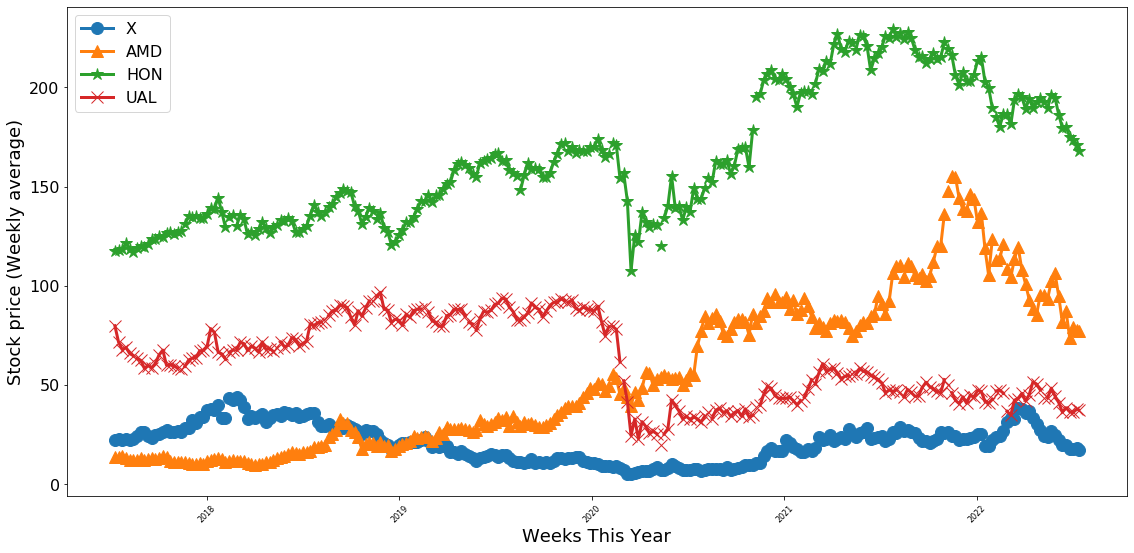

In [10]:
plt.figure(figsize=(19,9))
plt.plot(data['X'],lw=3,marker='o',markersize=12)
plt.plot(data['AMD'],lw=3,marker='^',markersize=12)
plt.plot(data['HON'],lw=3,marker='*',markersize=12)
plt.plot(data['UAL'],lw=3,marker='x',markersize=12)
plt.legend(['X', 'AMD', 'HON', 'UAL'],fontsize=16)
plt.xlabel("Weeks This Year",fontsize=18)
plt.ylabel("Stock price (Weekly average)",fontsize=18)
plt.xticks(fontsize=8)
plt.xticks(rotation = 45)
plt.yticks(fontsize=16)
plt.show()

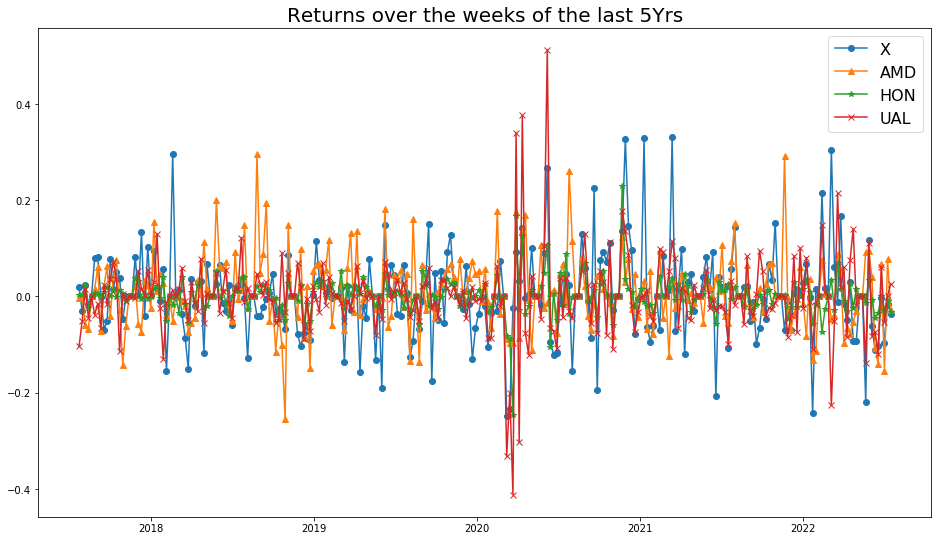

In [11]:
plt.figure(figsize = (16,9))
plt.plot(data_returns['X'], marker='o')
plt.plot(data_returns['AMD'], marker='^')
plt.plot(data_returns['HON'], marker='*')
plt.plot(data_returns['UAL'],marker='x')
plt.legend(['X', 'AMD', 'HON', 'UAL'],fontsize=16)
plt.title("Returns over the weeks of the last 5Yrs", fontsize=20)
plt.show()

In [12]:
#Using sum to accumulate the returns over this time period
r = np.asarray(np.sum(data_returns, axis=0))
r = np.array([r])
r

array([[2.40593685, 0.53545362, 0.11931827, 0.73693193]])

In [13]:
C = data_returns.cov()
C

,AMD,HON,UAL,X
AMD,0.005428,0.001052,0.001746,0.001218
HON,0.001052,0.001381,0.001992,0.001326
UAL,0.001746,0.001992,0.006686,0.002905
X,0.001218,0.001326,0.002905,0.007937


In [14]:
# Number of variables
n = len(etf)

# The variables vector
x = cp.Variable(n)

# Setting a minimum return
req_return = 0.95

#Return
ret = r*x

# The risk in xT.Q.x format
# Using the quadform for the risk ^
risk = cp.quad_form(x, C)

# The core problem with constraints of the portfolio I would like... at least 10% of HON ect.
prob = cp.Problem(cp.Minimize(risk), [sum(x)==1, ret >= req_return, x >= 0, x[3]>= 0.075, x[2]>=0.1])

/Users/mikesepe/opt/anaconda3/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)


In [15]:
#Solving the CVXPY problem and extracting values
prob.solve()
print ("Optimal portfolio")
print ("----------------------")
for s in range(len(etf)):
    print (" Investment in {} : {}% of the portfolio".format(etf[s],round(100*x.value[s],2)))
print ("----------------------")
print ("Exp ret over the given time period= {}%".format((100*ret.value)))
print ("Expected risk    = {}%".format(round(100*risk.value**0.5,2)))

Optimal portfolio
----------------------
 Investment in AMD : 23.58% of the portfolio
 Investment in X : 58.92% of the portfolio
 Investment in HON : 10.0% of the portfolio
 Investment in UAL : 7.5% of the portfolio
----------------------
Exp ret over the given time period= [95.]%
Expected risk    = 4.13%


## Monte Carlo to Visualize

In [16]:
num_iterations = 10000
simulation_res = np.zeros((4+len(etf)-1,num_iterations))

In [17]:
for i in range(num_iterations):
#Select random weights and normalize to set the sum to 1
        weights = np.array(np.random.random(len(etf)))
        weights /= np.sum(weights)
        #sim returns
        portfolio_return = np.sum(data_returns.mean() * weights)
        portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(C, weights)))
        #returns and strdev
        simulation_res[0,i] = portfolio_return
        simulation_res[1,i] = portfolio_std_dev
        #sharp ratio
        simulation_res[2,i] = simulation_res[0,i] / simulation_res[1,i]
        for j in range(len(weights)):
            simulation_res[j+3,i] = weights[j]

In [18]:
sim_frame = pd.DataFrame(simulation_res.T,columns=['ret','stdev','sharpe',etf[0],etf[1],etf[2],etf[3]])
print (sim_frame.head())
print (sim_frame.tail())

        ret     stdev    sharpe       AMD         X       HON       UAL
0  0.005185  0.053801  0.096382  0.497425  0.216585  0.275420  0.010570
1  0.001967  0.056097  0.035061  0.026672  0.307732  0.333704  0.331892
2  0.005014  0.049735  0.100817  0.455930  0.339705  0.195497  0.008869
3  0.002852  0.045883  0.062153  0.154065  0.476338  0.249005  0.120593
4  0.001956  0.057623  0.033947  0.009335  0.300071  0.293890  0.396704
           ret     stdev    sharpe       AMD         X       HON       UAL
9995  0.003848  0.055944  0.068788  0.285203  0.108946  0.302096  0.303755
9996  0.003566  0.053928  0.066132  0.250820  0.177701  0.305882  0.265597
9997  0.004387  0.053548  0.081920  0.402888  0.224288  0.355000  0.017824
9998  0.003524  0.044780  0.078701  0.184776  0.496846  0.041110  0.277268
9999  0.003240  0.049669  0.065229  0.229360  0.343184  0.331887  0.095569


### Shapre Ratio return over standard deviation (measure of volatility)

In [19]:
#Position of the portfolio with highest Sharpe Ratio
max_sharpe = sim_frame.iloc[sim_frame['sharpe'].idxmax()]

In [20]:
#Spot the position of the portfolio with minimum /max Standard Deviation
min_std = sim_frame.iloc[sim_frame['stdev'].idxmin()]
max_std = sim_frame.iloc[sim_frame['stdev'].idxmax()]

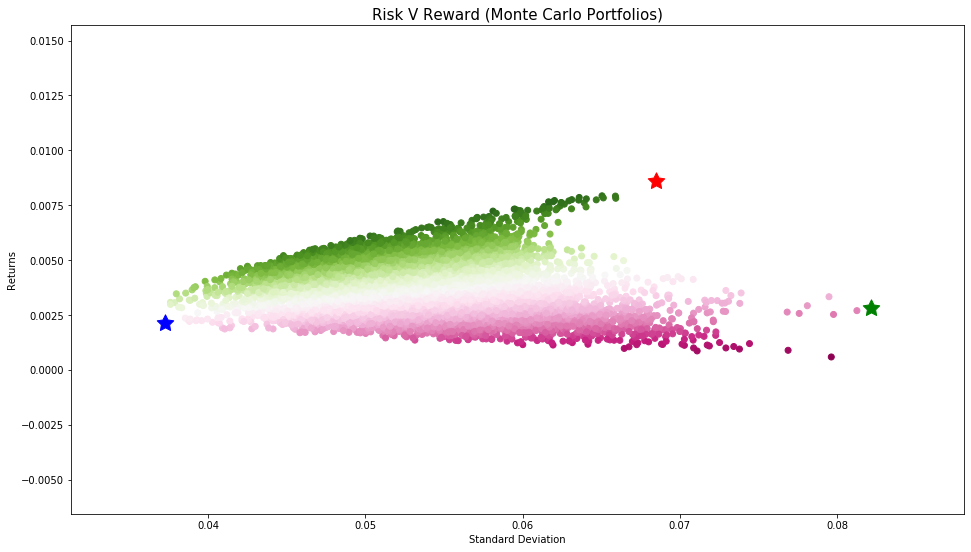

In [25]:
plt.figure(figsize=(16,9))
plt.scatter(sim_frame.stdev,sim_frame.ret,c=sim_frame.sharpe,cmap='PiYG')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
#showing the importance of returns over risk
plt.scatter(max_sharpe[1],max_sharpe[0],marker=(5,1,0),color='r',s=300)
plt.scatter(min_std[1],min_std[0],marker=(5,1,0),color='b',s=300)
plt.scatter(max_std[1], max_std[0], marker=(5,1,0), color='g', s=300)
plt.title('Risk V Reward (Monte Carlo Portfolios)', fontsize=15)
plt.show()

In [22]:
print ("The portfolio for min risk:\n", min_std)
print ("The portfolio for max Sharpe Ratio:\n", max_sharpe)
print ("The portfolio for max Std_Dev:\n", max_std)

The portfolio for min risk:
 ret       0.002131
stdev     0.037253
sharpe    0.057200
AMD       0.007973
X         0.949667
HON       0.004447
UAL       0.037913
Name: 1996, dtype: float64
The portfolio for max Sharpe Ratio:
 ret       0.008585
stdev     0.068489
sharpe    0.125342
AMD       0.908980
X         0.056864
HON       0.003240
UAL       0.030916
Name: 3719, dtype: float64
The portfolio for max Std_Dev:
 ret       0.002798
stdev     0.082128
sharpe    0.034070
AMD       0.020304
X         0.034164
HON       0.054468
UAL       0.891065
Name: 792, dtype: float64


### When looking at Std_dev (volitility)... keep in mind that these data include the onset of the pandemic in 2020!!!